<a href="https://www.nvidia.com/dli"> <img src="../images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a>

# Authorship Attribution

Authorship attribution is a type of text classification problem.  Instead of categorizing text by _topic_, as we did in the disease text classification problem, the objective is to classify the text by _author_.  

The inherent assumption in trying to solve a problem like this is that there is *some difference between the styles* of the authors in question, *which can be discerned by a model*.  Is that the case for BERT et al?  Is a language model able to "understand" written style? 

# The Problem
### The Federalist Papers - History Mystery!

The [Federalist Papers](https://en.wikipedia.org/wiki/The_Federalist_Papers) are a set of essays written between 1787 and 1788 by Alexander Hamilton, James Madison and John Jay.  Initially published under the pseudonym 'Publius', their intent was to encourage the ratification of the then-new Constitution of the United States of America.  In later years, a list emerged where the author of each one of the 85 papers was identified.  Nevertheless, for a subset of these papers the author is still in question.  The problem of the Federalist Papers authorship attribution has been a subject of much research in statistical NLP in the past.   Now we will try to solve this question with our own BERT-based project model.
                                                                                                           
In concrete terms, the problem is identifying, for each one of the disputed papers, whether Alexander Hamilton or James Madison are the authors.  For this exercise, we can assume that each paper has a single author, i.e., that no collaboration took place (though *that* is not 100% certain!), and that each author has a well-defined writing style that is displayed across all the identified papers. 

### This Project
we are provided with labeled `train.tsv` and `dev.tsv` datasets for the project.  There are 10 test sets, one for each of the disputed papers.  All datasets are contained in the `data/federalist_papers_HM` directory.  

Each "sentence" is actually a group of sentences of approximately 256 words.  The labels are '0' for HAMILTON and '1' for MADISON.  There are more papers by Hamilton in the example files than by Madison.  The validation set has been created with approximately the same distribution of the two labels as in the training set.

our task is to build neural networks using NeMo, as we did in Lab 2.  we'll train our model and test it.  Then we'll use provided collation code to see what answers our model gives to the "history mystery"!

# Preparing the Data

In [1]:
# Import useful math and utility libraries
import os
import json
import math
import json
import pickle
import numpy as np
import pandas as pd
pd.options.display.max_colwidth = -1
import torch

# Import the nemo toolkit and NLP libraries
import nemo
import nemo.collections.nlp as nemo_nlp

# Import the specific neural modules we need
from nemo.collections.nlp.nm.data_layers import BertTextClassificationDataLayer
from nemo.collections.nlp.nm.trainables import get_pretrained_lm_model, SequenceClassifier
from nemo.backends.pytorch.common.losses import CrossEntropyLossNM
    
# Import helpers for fetching the learning rate and tokenizer functions
from nemo.utils.lr_policies import get_lr_policy
from nemo.collections.nlp.data.tokenizers import get_tokenizer

# Import callbacks and callback functions
from nemo.core import SimpleLogger, TensorboardLogger, EvaluatorCallback, CheckpointCallback
from nemo.collections.nlp.callbacks.text_classification_callback import eval_iter_callback, eval_epochs_done_callback

# Identify the input data location.
DATA_DIR = '/dli/task/data/federalist_papers_HM/'

[NeMo W 2021-06-21 18:49:13 audio_preprocessing:56] Could not import torchaudio. Some features might not work.


In [2]:
# Identify the pretrained model 
# and where information and checkpoints will be logged

# PRETRAINED_MODEL_NAME = 'bert-base-uncased'
# WORK_DIR = '/dli/task/data/logs-bbu/'

PRETRAINED_MODEL_NAME = 'bert-base-cased'
WORK_DIR = '/dli/task/data/logs-bbc/'

# PRETRAINED_MODEL_NAME = 'megatron-bert-345m-uncased'
# WORK_DIR = '/dli/task/data/logs-m345u/'

# PRETRAINED_MODEL_NAME = 'bert-large-uncased'
# WORK_DIR = '/dli/task/data/logs-blu/'

### Setting sizing parameters

In [3]:
# Set the number of words in the sequences
# Set the number of classes for the classifier
# Set the batch size for processing
MAX_SEQ_LEN = 128 #FIXME 
NUM_CLASSES = 2 #FIXME
BATCH_SIZE = 64#FIXME
# To use mixed precision, set AMP_OPTIMIZATION_LEVEL to 'O1' or 'O2',
# to train without mixed precision, set it to 'O0'.
AMP_OPTIMIZATION_LEVEL = 'O1'

In [4]:
# Run to save for assessment- DO NOT CHANGE
with open("my_assessment/step1.json", "w") as outfile: 
    json.dump([MAX_SEQ_LEN, NUM_CLASSES, BATCH_SIZE], outfile) 

# Preparing the Training Pipeline

### NeuralModuleFactory

In [5]:
# Instantiate the neural module factory
nf = nemo.core.NeuralModuleFactory(log_dir=WORK_DIR,
                                   create_tb_writer=True,
                                   add_time_to_log_dir=False,
                                   optimization_level=AMP_OPTIMIZATION_LEVEL)

### Creating the Training Neural Modules

In [10]:
# Instantiate the data Layer neural module for training.
#     Include the input file locations, tokenizer, max_seq_length, and batch size.
#     Set the shuffle and use_cache to True for training  
USE_CACHE = True
tokenizer = get_tokenizer(tokenizer_name='nemobert', pretrained_model_name=PRETRAINED_MODEL_NAME)
dl_train = BertTextClassificationDataLayer(input_file=(DATA_DIR+'train.tsv'),
                                          tokenizer=tokenizer,
                                          max_seq_length=MAX_SEQ_LEN,
                                          batch_size=BATCH_SIZE,
                                          use_cache=USE_CACHE,
                                          shuffle=True) #FIXME

# Sanity check
print('dl_train features include batchsize of {} and shuffle = {}'.format(dl_train._batch_size, dl_train._shuffle))

[NeMo I 2021-06-21 19:14:40 bert_tokenizer:78] Deriving bert model type from pretrained model name.
[NeMo I 2021-06-21 19:14:40 text_classification_dataset:217] features restored from /dli/task/data/federalist_papers_HM/cached_train_BertTokenizer_128_28996
dl_train features include batchsize of 64 and shuffle = True


In [11]:
# Instantiate the Language Model with the get_pretrained_lm_model function
#    Include the pretrained_model_name as the parameter
lm = get_pretrained_lm_model(pretrained_model_name=PRETRAINED_MODEL_NAME) 

# Sanity check the number of weight parameters
print(f'{PRETRAINED_MODEL_NAME} has {lm.num_weights} weights')


bert-base-cased has 108310272 weights


In [12]:
# Instantiate the SequenceClassifier
#    Include the hidden_size, num_classes (which is NUM_CLASSES), num_layers (set to 2), 
#    and a dropout rate of 0.1
lm_hidden_size = lm.hidden_size
classifier = SequenceClassifier(hidden_size=lm_hidden_size,
                                num_classes=NUM_CLASSES,
                                num_layers=2,
                                dropout=0.1) #FIXME

# Sanity check the number of weight parameters
print(f'Classifier has {classifier.num_weights} weights')

Classifier has 592130 weights


In [13]:
# Instantiate the CrossEntropyLossNM Loss Function (no parameters required)
loss = CrossEntropyLossNM() #FIXME

# Sanity check the loss - it should be ModuleType "loss"
print(loss._type)

ModuleType.loss


In [14]:
# Run to save for assessment- DO NOT CHANGE
with open("my_assessment/step2.json", "w") as outfile: 
    json.dump([str(dl_train()), str(lm), str(classifier), str(loss)], outfile)

### Training Graph

In [15]:
# Define the data output from the data layer
train_data = dl_train()

# Define train_embeddings from the language model, based on inputs from the data layer  
train_embeddings = lm(input_ids=train_data.input_ids,
                      token_type_ids=train_data.input_type_ids,
                      attention_mask=train_data.input_mask)

# Define the train_logits from the clasifier, based on the embeddings from the language model
train_logits = classifier(hidden_states=train_embeddings)

# Define the train_loss based on the classifier logits and data layer labels
train_loss = loss(logits=train_logits, labels=train_data.labels)

# Sanity check the outputs
print('Types are:\n{}\n{}\n{}\n{}'.format(train_data, train_embeddings, train_logits, train_loss))

Types are:
BertTextClassificationDataLayerOutput(input_ids=<nemo.core.neural_types.neural_type.NmTensor object at 0x7f91194b8e80>, input_type_ids=<nemo.core.neural_types.neural_type.NmTensor object at 0x7f9119971898>, input_mask=<nemo.core.neural_types.neural_type.NmTensor object at 0x7f91199cdb70>, labels=<nemo.core.neural_types.neural_type.NmTensor object at 0x7f9119971d30>)
hidden_states
logits
loss


# Validation Pipeline

### Create the Validataion Data Layer Neural Module

In [17]:
# Instantiate the data Layer neural module for validation. 
dl_val = BertTextClassificationDataLayer(input_file=os.path.join(DATA_DIR, 'dev.tsv'),
                                             tokenizer=tokenizer,
                                             max_seq_length=MAX_SEQ_LEN,
                                             batch_size=BATCH_SIZE,
                                             use_cache=USE_CACHE)

# Sanity check
print('dl_val features include batchsize of {} and shuffle = {}'.format(dl_val._batch_size, dl_val._shuffle))

[NeMo I 2021-06-21 19:21:51 text_classification_dataset:217] features restored from /dli/task/data/federalist_papers_HM/cached_dev_BertTokenizer_128_28996
dl_val features include batchsize of 64 and shuffle = False


### Validation Graph

In [18]:
# Define the data output from the data layer
val_data = dl_val() #FIXME

# Define val_embeddings from the language model, based on inputs from the data layer  
val_embeddings = lm(input_ids=val_data.input_ids,
                    token_type_ids=val_data.input_type_ids,
                    attention_mask=val_data.input_mask) #FIXME

# Define val_logits from the clasifier, based on the embeddings from the language model
val_logits = classifier(hidden_states=val_embeddings) #FIXME

# Define val_loss based on the classifier logits and data layer labels
val_loss = loss(logits=val_logits, labels=val_data.labels) #FIXME

# Sanity check the types - they should be the same as for the training graph (not None!)
print('Types are:\n{}\n{}\n{}\n{}'.format(val_data, val_embeddings, val_logits, val_loss))

Types are:
BertTextClassificationDataLayerOutput(input_ids=<nemo.core.neural_types.neural_type.NmTensor object at 0x7f911822dd68>, input_type_ids=<nemo.core.neural_types.neural_type.NmTensor object at 0x7f911822def0>, input_mask=<nemo.core.neural_types.neural_type.NmTensor object at 0x7f911822de80>, labels=<nemo.core.neural_types.neural_type.NmTensor object at 0x7f911822dba8>)
hidden_states
logits
loss


# Training

### Calculating steps

In [20]:
NUM_EPOCHS = 15
NUM_GPUS = 1  # always should be 1 for these labs

train_data_size = len(dl_train)
steps_per_epoch = math.ceil(train_data_size / (BATCH_SIZE * NUM_GPUS))

### Setting optimizer and learning rate

In [21]:
OPTIMIZER = 'adam'
LEARNING_RATE = 1e-4
WARMUP_RATIO = 0.1

lr_policy_fn = get_lr_policy("WarmupAnnealing", 
                             total_steps=NUM_EPOCHS * steps_per_epoch, 
                             warmup_ratio=WARMUP_RATIO
)

### Creating the Callbacks

In [22]:
# Create callback for simple logging
train_callback = SimpleLogger(step_freq=steps_per_epoch)

# Create callback for tensorboard logging
tensorboard_callback = TensorboardLogger(nf.tb_writer,
                                        step_freq=steps_per_epoch)

# Create callback to evaluate each epoch against the validation data
eval_callback = EvaluatorCallback(eval_tensors=[val_logits, val_data.labels],
                                            user_iter_callback=lambda x, y: eval_iter_callback(x, y, dl_val),
                                            user_epochs_done_callback=lambda x:
                                                eval_epochs_done_callback(x, f'{nf.work_dir}graphs'),
                                            tb_writer=nf.tb_writer,
                                            eval_step=steps_per_epoch)

# Create callback to save checkpoints
ckpt_callback = CheckpointCallback(folder=nf.checkpoint_dir,
                                             epoch_freq=1)

### Running the Trainer

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
[NeMo I 2021-06-21 19:32:19 callbacks:534] Found 2 modules with weights:
[NeMo I 2021-06-21 19:32:19 callbacks:536] BERT
[NeMo I 2021-06-21 19:32:19 callbacks:536] SequenceClassifier
[NeMo I 2021-06-21 19:32:19 callbacks:537] Total model parameters: 108902402
[NeMo I 2021-06-21 19:32:19 callbacks:473] Found chec

[NeMo W 2021-06-21 19:32:19 callbacks:499] For module BERT, no file matches  in /dli/task/data/logs-bbc/checkpoints
[NeMo W 2021-06-21 19:32:19 callbacks:501] Checkpoint folder /dli/task/data/logs-bbc/checkpoints was present but nothing was restored. Continuing training from random initialization.


[NeMo I 2021-06-21 19:32:20 callbacks:232] loss: 0.67691934
[NeMo I 2021-06-21 19:32:20 deprecated_callbacks:316] Doing Evaluation ..............................
[NeMo I 2021-06-21 19:32:20 text_classification_callback:57] Accuracy: 0.7739130434782608
[NeMo I 2021-06-21 19:32:20 text_classification_callback:64] Sampled preds: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[NeMo I 2021-06-21 19:32:20 text_classification_callback:65] Sampled labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[NeMo I 2021-06-21 19:32:20 callback_utils:92] Confusion matrix:
    [[89  0]
     [26  0]]
[NeMo I 2021-06-21 19:32:20 text_classification_callback:67]               precision    recall  f1-score   support
    
               0     0.7739    1.0000    0.8725        89
               1     0.0000    0.0000    0.0000        26
    
        accuracy                         0.7739       115
       macro avg     0.3870    0.5000    0.4363       115
    weighted avg     0.5989    0.7739    0.6753       115
    

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[NeMo I 2021-06-21 19:32:22 callbacks:232] loss: 0.6782292
[NeMo I 2021-06-21 19:32:22 deprecated_callbacks:316] Doing Evaluation ..............................
[NeMo I 2021-06-21 19:32:22 text_classification_callback:57] Accuracy: 0.7739130434782608
[NeMo I 2021-06-21 19:32:22 text_classification_callback:64] Sampled preds: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[NeMo I 2021-06-21 19:32:22 text_classification_callback:65] Sampled labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[NeMo I 2021-06-21 19:32:22 callback_utils:92] Confusion matrix:
    [[89  0]
     [26  0]]
[NeMo I 2021-06-21 19:32:22 text_classification_callback:67]               precision    recall  f1-score   support
    
               0     0.7739    1.0000    0.8725        89
               1     0.0000    0.0000    0.0000        26
    
        accuracy                         0.7739       115
       macro avg     0.3870    0.5000    0.4363       115
    weighted avg     0.5989    0.7739    0.6753       115
    


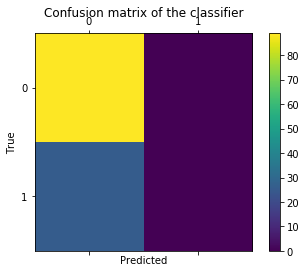

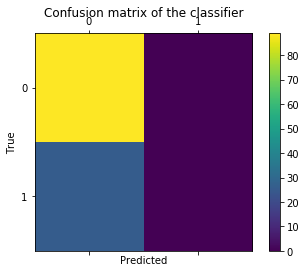

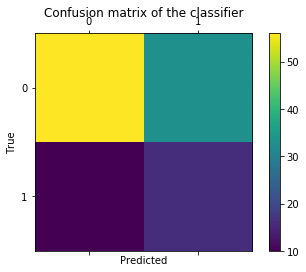

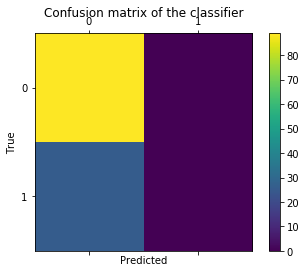

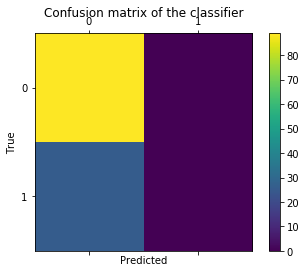

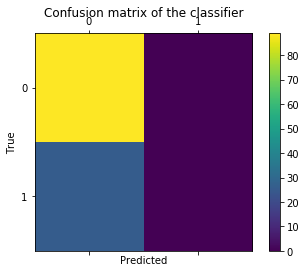

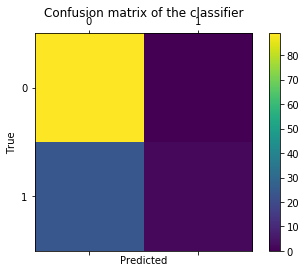

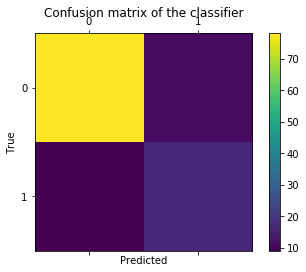

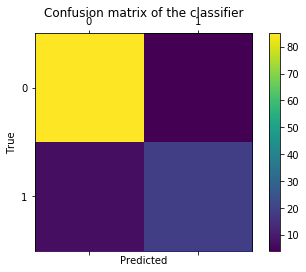

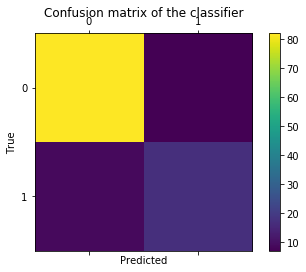

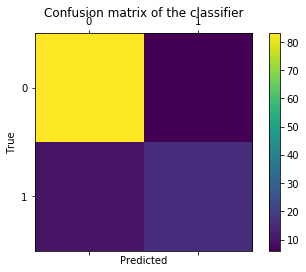

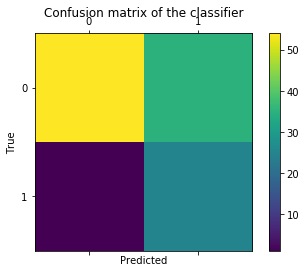

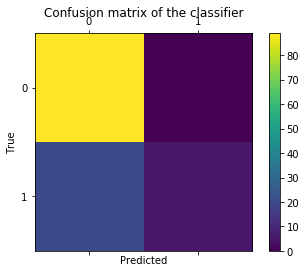

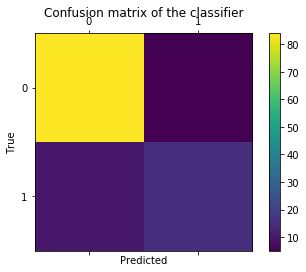

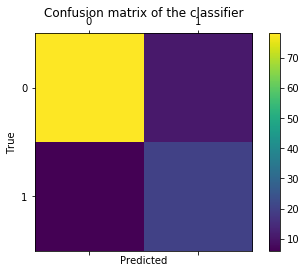

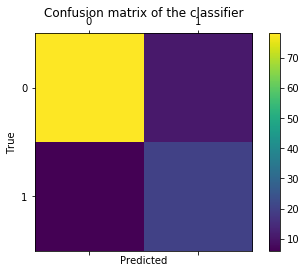

In [23]:
%%time
nemo.core.NeuralModuleFactory.reset_trainer(nf)
#FIXME Complete the nf.train parameters
nf.train(tensors_to_optimize=[train_loss],
         callbacks=[train_callback, tensorboard_callback, eval_callback, ckpt_callback],
         lr_policy=lr_policy_fn,
         optimizer=OPTIMIZER,
         optimization_params={'num_epochs': NUM_EPOCHS, 'lr': LEARNING_RATE})

# Inference

### Preparing the Test Data for Each Paper

In [25]:
def add_label_to_test_data(input_file, output_file):
    """ Add a nominal 'label' column to each test file and save it """
    df = pd.read_csv(input_file, sep='\t')
    if 'label' not in df:
        df['label'] = 0
        df = df[['sentence', 'label']]
    df.to_csv(output_file, sep='\t', index=False)
    
def sample_classification(sample):
    """ Extract the tensor probabilities from inference """
    sentence = sample.sentence
    prob0 = sample.prob0.values[0]
    prob1 = sample.prob1.values[0]
    result = f'{sentence} \n HAMILTON | MADISON \n {prob0} | {prob1}'
    return result

# Add the label column to all the test sets by disputed paper
test_files = [
    'test49.tsv',
    'test50.tsv',
    'test51.tsv',
    'test52.tsv',
    'test53.tsv',
    'test54.tsv', 
    'test55.tsv',
    'test56.tsv',
    'test57.tsv',
    'test62.tsv',
]

for test_file in test_files:
    add_label_to_test_data(DATA_DIR + test_file, DATA_DIR + 'labeled_' + test_file)

### Creating Test Inference Runner

In [26]:
def classify_paper(nf, tokenizer, bert, mlp, test_file, save_file):
    """ Run inference on a test_file and save the probabilities found """
    
    # Create the data layer neural module and test graph
    dl_tmp = BertTextClassificationDataLayer(input_file=test_file,
                                               tokenizer=tokenizer,
                                               max_seq_length=MAX_SEQ_LEN,
                                               batch_size=1)
    
    tmp_data = dl_tmp()
    tmp_embeddings = bert(input_ids=tmp_data.input_ids,
                          token_type_ids=tmp_data.input_type_ids,
                          attention_mask=tmp_data.input_mask)
    tmp_logits = mlp(hidden_states=tmp_embeddings)
    
    # Run inference
    tmp_logits_tensors = nf.infer(tensors=[tmp_logits, tmp_embeddings])
    
    # Convert the tensor likelilhoods to probabilities and save
    tmp_probs = [torch.nn.functional.softmax(torch.cat(tmp_logits_tensors[0]), dim=1).numpy()[:, label_index] for label_index in range(NUM_CLASSES)]
    tmp_df = pd.read_csv(test_file, sep='\t')
    tmp_df['prob0'] = tmp_probs[0] 
    tmp_df['prob1'] = tmp_probs[1]
    tmp_df.to_csv(save_file, sep='\t', index=False)
    
    # Prepare an information output string
    avg = round(float(tmp_df['prob0'].mean()),3)
    std = round(float(tmp_df['prob0'].std()),3)
    name = 'HAMILTON' if avg > 0.5 else 'MADISON'
    result_string = '{} {} mean: {} std: {}\n'.format(name, test_file, avg, std)
    return result_string

### Running Inference

In [27]:
print_collated_output = ''
for test_file in test_files:
    result = classify_paper(nf, tokenizer, lm, classifier, DATA_DIR + 'labeled_' + test_file, DATA_DIR + 'inference_result_' + test_file)
    print_collated_output += result

[NeMo I 2021-06-21 19:40:56 text_classification_dataset:82] /dli/task/data/federalist_papers_HM/labeled_test49.tsv: 7
[NeMo I 2021-06-21 19:40:56 data_preprocessing:250] Min: 262 |                  Max: 348 |                  Mean: 295.14285714285717 |                  Median: 288.0
[NeMo I 2021-06-21 19:40:56 data_preprocessing:252] 75 percentile: 304.0
[NeMo I 2021-06-21 19:40:56 data_preprocessing:253] 99 percentile: 346.14
[NeMo I 2021-06-21 19:40:56 text_classification_dataset:118] 7 out of 7                         sentences with more than 128 subtokens.
[NeMo I 2021-06-21 19:40:56 text_classification_dataset:175] *** Example ***
[NeMo I 2021-06-21 19:40:56 text_classification_dataset:176] example_index: 0
[NeMo I 2021-06-21 19:40:56 text_classification_dataset:177] subtokens: [CLS] ##ca ##ution ##s which he proposes , and on which he appears ultimately to rely as a p ##all ##adi ##um to the weaker departments of power against the invasions of the stronger , is perhaps altogether

In [28]:
print(print_collated_output)

MADISON /dli/task/data/federalist_papers_HM/labeled_test49.tsv mean: 0.437 std: 0.517
MADISON /dli/task/data/federalist_papers_HM/labeled_test50.tsv mean: 0.257 std: 0.493
MADISON /dli/task/data/federalist_papers_HM/labeled_test51.tsv mean: 0.384 std: 0.436
MADISON /dli/task/data/federalist_papers_HM/labeled_test52.tsv mean: 0.311 std: 0.382
MADISON /dli/task/data/federalist_papers_HM/labeled_test53.tsv mean: 0.335 std: 0.466
MADISON /dli/task/data/federalist_papers_HM/labeled_test54.tsv mean: 0.062 std: 0.154
MADISON /dli/task/data/federalist_papers_HM/labeled_test55.tsv mean: 0.367 std: 0.495
MADISON /dli/task/data/federalist_papers_HM/labeled_test56.tsv mean: 0.433 std: 0.472
MADISON /dli/task/data/federalist_papers_HM/labeled_test57.tsv mean: 0.429 std: 0.488
MADISON /dli/task/data/federalist_papers_HM/labeled_test62.tsv mean: 0.428 std: 0.432



We can open the individual `inference_result_testXX.tsv` file to see the detailed results.